# Assignment 3 - Face Recognition using Eigenfaces

In this assigment we will implement and apply PCA to a dataset of celebrity faces, before finally building a very simple face classifier. To do this, we are going to: preprocess our images, implement PCA, and finally visualize the results of applying it to our dataset.

Complete the sections of the assignment prefixed with **"TODO"**:

* [2. PCA](#scrollTo=EHMIljnpdaBE)
* [3.1 Eigenfaces](#scrollTo=A_JqQwEmu7ef)
* [3.2 Eigenfaces](#scrollTo=YTdZF-O6daaK)
* [4.2 Face Classification](#scrollTo=IDhubLwVh2Vr)


## 1) Preparing the Dataset

First, we need to download the dataset and preprocess the data. To accomplish this, we will load the images into a (N, H, W) NumPy matrix (where N is the number of images, and H, W are the image dimensions). Furthermore, we will also need to center crop the images to remove the background and only keep the face in the images. As an aside, it is also reccomended to make sure the images in our dataset are aligned (e.g., eyes, nose, etc.); the dataset we will be using has already done this for us.

**Bonus:** If you have a few pictures of your friends, you can also supplement the dataset using their photos! Later on we will be building a face recognition system for which you use these photos to test.




### 1.1) First, download the dataset and extract the images

In [65]:
# Download the dataset (subset of CelebA).
!wget -O a3_face_dataset.tar.gz https://www.dropbox.com/s/4nmsiafyvw0o5fx/a3_face_dataset.tar.gz?dl=0

--2020-02-18 04:34:52--  https://www.dropbox.com/s/4nmsiafyvw0o5fx/a3_face_dataset.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4nmsiafyvw0o5fx/a3_face_dataset.tar.gz [following]
--2020-02-18 04:34:52--  https://www.dropbox.com/s/raw/4nmsiafyvw0o5fx/a3_face_dataset.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc030305eded935c5e763a4aa908.dl.dropboxusercontent.com/cd/0/inline/AyUJ4zeeQR28kCyztz0LU61shbt4zJPyY4NfsAE5O6vbNmpNLnuvjmFrVZS_A8qiVCnySWPRi3ElF_oZv_aZp31MvmKCX96L032Lcj6lzGi_TEEPVT9fD9L5NqIImVsCsy4/file# [following]
--2020-02-18 04:34:52--  https://uc030305eded935c5e763a4aa908.dl.dropboxusercontent.com/cd/0/inline/AyUJ4zeeQR28kCyztz0LU61shbt4zJPyY4NfsAE5O6vbNmpNLnuvjmFrVZS_A8qiVCnySWPRi3ElF_o

In [66]:
# Extract the contents of the compressed file.
!tar xzf a3_face_dataset.tar.gz
!ls

a3_face_dataset  a3_face_dataset.tar.gz  eigenfaces  sample_data


### 1.2) Preview a few images from the dataset

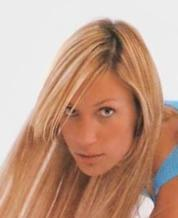

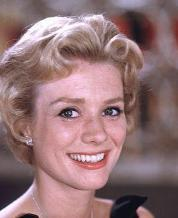

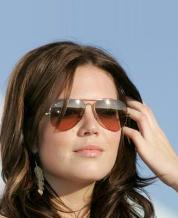

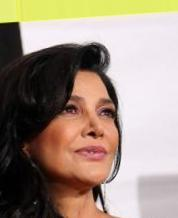

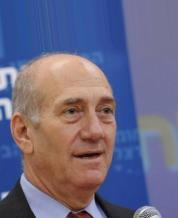

In [67]:
import glob
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Display the first images from the dataset. You can also browse these by
# navigating through the notebooks file system!
sample_images = glob.glob('a3_face_dataset/*.jpg')[:5]
for file_path in sample_images:
  display(Image(file_path))

### 1.3) Load the dataset and convert into a NumPy matrix

In [68]:
import cv2
import numpy as np

# Load images in greyscale.
image_paths = list(glob.glob('a3_face_dataset/*.jpg'))
images = np.stack([cv2.imread(str(x), cv2.IMREAD_GRAYSCALE) 
                   for x in image_paths])
print('Original Image Shape (N, H, W):', images.shape)

Original Image Shape (N, H, W): (500, 218, 178)


###1.4) Center crop the images and visualize the results

Cropped Image Shape (N, H, W): (500, 108, 88)


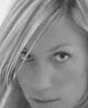

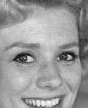

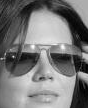

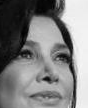

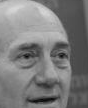

In [69]:
import PIL

# Helper function for cropping the center of the image to remove the background
# and only keep the face.
def center_crop(img):
    h, w = img.shape
    center_y, center_x = h // 2, w // 2
    offset_y, offset_x = center_y // 2, center_x // 2
    return img[center_y - offset_y: center_y + offset_y,
               center_x - offset_x: center_x + offset_x]
  
# Center crop our images.
images = np.stack([center_crop(img) for img in images])
img_height, img_width = images.shape[1:3]
print('Cropped Image Shape (N, H, W):', images.shape)

# Visualize a few results.
for i in range(5):
  display(PIL.Image.fromarray(images[i]))

###1.5) Lastly, flatten each image into a single vector

In [70]:
# Flatten the images into a (N, HxW) sized array, where N is the number of 
# images and H, W are the dimensions of the image.
num_images = len(images)
images = images.reshape(num_images, -1)
print('Matrix Shape (N, H*W):', images.shape)

Matrix Shape (N, H*W): (500, 9504)


## 2) PCA Implementation

**Note that there are several methods to solve for the eigenvectors of a matrix; for this assignment, you must use the eigenvectors of $A^TA$ to solve for those
of $AA^T$. Please read the following 'Theory' section carefully for more details.** 





### 2.1) Theory

The simplest way to implement PCA is to compute the covariance
matrix and solve for the eigenvalues and eigenvectors. For the derivation,
we will use the notation that our input, $A$, is a matrix with a row for each pixel in the input image, and a column for each sample (i.e., $A = X^T$). In this case, that means $A$ should be a $9504$x$500$ dimensional matrix, where $n=500$. Lastly, we will also presume that $X$ is zero-centered and has a mean of zero.

The covariance matrix is given by $\mathrm{cov}(A) =  \frac{1}{n}AA^T$, resulting in a $9504$x$9504$ matrix for which we need to solve the eigenvalues and eigenvectors. In reality, this approach is impractical as it is extremely time consuming to work with such large matrices (e.g., if we were to work with HD images, this matrix would contain on the order of $10^{12}$ elements).

Instead, we will use a clever trick to work around this: if we can find a mapping between the eigenvectors of $\mathrm{cov}(A^T)$ to those of $\mathrm{cov}(A)$, then we only have to work with a $500$x$500$ matrix. This saves an immense amount of computation so long as the number of data samples is less than the number of pixels (which is almost always the case).

**Your task will be to complete / make sense of the following derivation, and then use it to implement PCA.** As an aside, note that the constant term $n$ has been omitted for simplification.
$$
\mathrm{cov}(A^T)v = \lambda v \\
A^TAv =  \lambda v \\
AA^TAv = A\lambda v \\
...
$$
____________________________________________________

For further reading, please refer to the class notes and the following resources as a guideline for implementing PCA. Keep in mind that notation may vary between resources; make sure that your matrices are arranged in the correct order:
* https://en.wikipedia.org/wiki/Eigenface  
* https://en.wikipedia.org/wiki/Eigenface#Computing_the_eigenvectors  
* http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf  
* http://www.face-rec.org/algorithms/pca/jcn.pdf


### 2.2) Implementation

For this assignment we will be implementing PCA using only linear algebra libraries. As a guideline, we will loosely follow
the interface of the scikit-learn version of PCA.

In [0]:
class PCA:
    """
    Custom implementation of PCA with an interface similar to scikit-learn's version of PCA.
    """

    def __init__(self, n_components):
        self.n_components_ = n_components
        self.mean_ = None
        self.components_ = None
        self.eigenvalues_ = None

    # TODO
    def fit(self, x):
        x = x.astype(np.float32)

        # Normalize X so that it has a mean of 0. You can accomplish this
        # by computing the mean image vector and subtracting it from X.
        # --> Your code here <--

        # first compute the mean image vector 
        self.mean_ = np.mean(x, axis=0)
        # to each images, substract the average face 
        x = x - self.mean_

        # Set-up your variables, A, and A^TA
        # --> Your code here <--
        A = x.T # x is 500 by 9504, A should be 9504 by 500
        At_A = np.dot(x, A) # = Cov(A^T)

        # Sanity check.
        assert A.shape == (9504, 500)
        assert At_A.shape == (500, 500)

        # Compute the eigenvectors using the method discussed above.
        # --> Your code here <--

        # A^TA and AA^Thave the same eigenvalues and the eigenvectors of AA^T are u = Av where v represents the eigenvectors of A^TA 

        # 1. compute eigenvectors for A^TA
        eigvalues, eigvectors = np.linalg.eig(At_A)
        # let eigeinvectors for AA^T = ui = Avi (i.e eigenfaces)
        eigenvectors = np.dot(A, eigvectors)

        # Tranpose the dimensions of your eigenvectors to return to the
        # notation where each eigenvector is it's own row.
        eigenvectors = eigenvectors.T
        assert eigenvectors.shape == (500, 9504)

        # Ensure that each of the N eigenvectors are normalized to a magnitude of 1.
        # --> Your code here <--
        
        # the function from numpy already returned normalized eigenvectors

        # Only retain the best N components (eigenvectors). These should be assigned
        # to the 'self.components_' attribute.
        # --> Your code here <--

        # make a pair of the eigenvalues and eigenvectors
        eigen = sorted([(eigvalues[i], eigenvectors[i]) for i in range(len(eigvalues))], reverse=True)

        self.components_ = [eigen[i][1] for i in range(self.n_components_)]
        self.components_ = np.array(self.components_)

        # Keep all of the eigenvalues, but make sure to sort them. This is done so we can
        # visualize the variance versus number of components kept later in the assignment.
        # This should be assigned to the 'self.eigenvalues_' attribute.
        # --> Your code here <--
        self.eigenvalues_ = eigvalues
        assert self.eigenvalues_.shape == (500, )

    def transform(self, x):
      x = x.astype(np.float32)
      result = []

      # Project the input vector 'x' onto your PCA object's principal
      # components and return the result. Make sure you subtract the mean face
      # like in the fit(...) method.
      # --> Your code here <--

      x = x - self.mean_
      
      for img in x:
        img_result = np.dot(img, self.components_.T)
        result.append(img_result)

      return np.array(result)

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

## 3) Computing Eigenfaces

With the implementation of PCA complete, lets try running it on our dataset and visualizing some of the eigenfaces of the training set. To accomplish this, we first run PCA on the training matrix and then we take the eigenvectors and plot them as 2D images.

###3.1) Perform PCA on our image matrix

In [0]:
# Settings
num_components = 50

# TODO: PCA. Create a PCA instance and fit it on the training data.
# --> Your code here <--
pca = PCA(num_components)
images = pca.fit_transform(images)

###3.2) Visualize the eigenfaces

Saving mean face...Done.
Saving first ten eigen-faces to ./outputs/...Mean Face


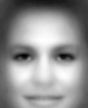

Eigenfaces


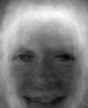

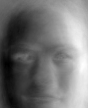

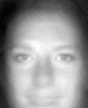

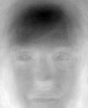

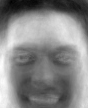

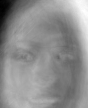

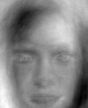

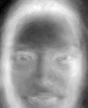

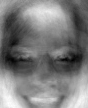

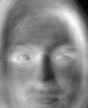

In [74]:
import os

# Output directory.
os.makedirs('./eigenfaces/', exist_ok=True)

# Visualize the mean face.
print('Saving mean face...', end='')
mean_face = pca.mean_.reshape(img_height, img_width)
norm_img = cv2.normalize(mean_face, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('./eigenfaces/mean_face.png', norm_img)
print('Done.')

# TODO: Visualize the first few eigenfaces, and save them as './eigenfaces/eigenface_{i}.png'.
# Don't forget to normalize the image like the the mean face example above.
print('Saving first ten eigen-faces to ./outputs/...', end='')
eigenfaces = pca.components_.reshape(num_components, img_height, img_width)[:10]
# --> Your code here <--
# normalize the eigenfaces
for i, face in enumerate(eigenfaces):
  face = face.reshape(img_height, img_width)
  normalized_face = cv2.normalize(face, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
  # saving the images
  path = './eigenfaces/eigenface_'+ str(i) + '.png'
  cv2.imwrite(path, normalized_face)

# Display the mean face and eigenfaces. You can also browse these by
# navigating through the notebooks file system (see left side toolbar)!
print('Mean Face')
display(Image('./eigenfaces/mean_face.png'))

print('Eigenfaces')
for i in range(10):
  display(Image(f'./eigenfaces/eigenface_{i}.png'))

###3.3) Variance versus number of components

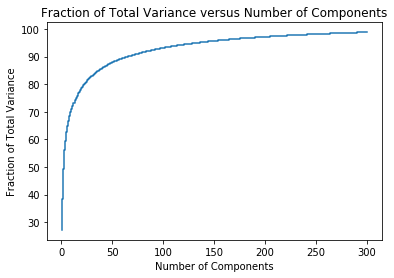

In [75]:
import matplotlib.pyplot as plt

# Compute the cumulative sum of total variance as we increase the number of 
# principal components we use.
n_components_to_plot = 300
total_variance = sum(pca.eigenvalues_)
var_exp = [(i / total_variance) * 100 for i in
           sorted(pca.eigenvalues_, reverse=True)[:n_components_to_plot]]
cum_var_exp = np.cumsum(var_exp)

# Generate the plot.
plt.step(range(1, n_components_to_plot + 1), cum_var_exp)
plt.title('Fraction of Total Variance versus Number of Components')
plt.ylabel('Fraction of Total Variance')
plt.xlabel('Number of Components')
plt.show()

## 4) Face Recognition

In this section, we're going to build a simple face recognition system using eigenfaces. To accomplish this, we're going to take a test image and project it onto our principal components learned from our training set of celebrity faces. Finally, we will compare the resulting vector to all of the other faces in the training set and find the closet match based on Euclidean distance (i.e., 1-nearest-neighbour classification).

For instance, this training set has photos of Obama—in theory then, if we were to test another photo of Obama (not in the training set, cropped and aligned), we should find that the closest match in the training set will also be a photo of Obama.

### 4.1) Download the test image

--2020-02-18 04:36:00--  https://www.dropbox.com/s/ffw2621k0gmix1z/006357.jpg?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ffw2621k0gmix1z/006357.jpg [following]
--2020-02-18 04:36:00--  https://www.dropbox.com/s/raw/ffw2621k0gmix1z/006357.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc04057db573319feb90ddebff83.dl.dropboxusercontent.com/cd/0/inline/AyW-DB404DswWHZYMyGZBiqmzW83QhHogTSewuih8kD_zvvXM4ScA4OpBBhMwMVm2t8mv8nT-EOWWvEn2uAEZi_Rzid1rQOJglNNaMeG8HuoZR1yVK1J_zjzkoIkox7Tpn8/file# [following]
--2020-02-18 04:36:00--  https://uc04057db573319feb90ddebff83.dl.dropboxusercontent.com/cd/0/inline/AyW-DB404DswWHZYMyGZBiqmzW83QhHogTSewuih8kD_zvvXM4ScA4OpBBhMwMVm2t8mv8nT-EOWWvEn2uAEZi_Rzid1rQOJglNNaMeG8HuoZR1yVK1

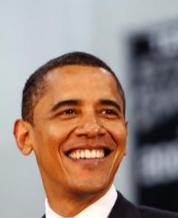

In [76]:
# Download a photo of Obama which isn't in the training set.
!wget -O "006357.jpg" https://www.dropbox.com/s/ffw2621k0gmix1z/006357.jpg?dl=0
display(Image('006357.jpg'))

### 4.2) Find the closet image in the training set to our test image

Best match: a3_face_dataset/141747.jpg


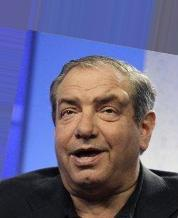

In [81]:
from numpy.linalg import norm

# Load our test image into a NumPy matrix
test_img = center_crop(cv2.imread('006357.jpg', cv2.IMREAD_GRAYSCALE))
test_img = np.expand_dims(test_img.flatten(), axis=0)

# TODO: Transform our training matrix and test image using our PCA implementation
# from earlier.
# --> Your code here <--
test = pca.transform(test_img).flatten()
import math 

# TODO: For our face recognition classifier, we will use a 1-nearest-neighbour
# model. The classifier should return the index of the best matching image.
# --> Your code here <--
best_match_index = None

# to compare the images, use euclidean distance between test img and training images
def euclidean(test_img, train_img, length):
  # find the euclidean distance from all the elements in test/train img
  distance = 0
  for i in range(length):
    distance += (test_img[i] - train_img[i])**2
  
  return math.sqrt(distance)

# now get the distance matrix from test image and training images
length = len(test)

def find_best_match(test, images, length):
  # first assume the min dist to be the first euclidean distance  
  min_dist = euclidean(test, images[0], length)
  index = 0
  for i in range(len(images)):
    tmp = euclidean(test, images[i], length) # we get a distance
    if tmp < min_dist:
      min_dist = tmp
      index = i
  return index

best_match_index =  find_best_match(test, images, length)

# If it goes well, the best match in our training set should be another photo of Obama.
print('Best match:', image_paths[best_match_index])
display(Image(image_paths[best_match_index]))